In [306]:
# load in sdf files for:
# Mpro-x2646 (TRY-UNI-714a760b-6)
# Mpro-P0950 (ALP-POS-e0fe77e5-13)
# Mpro-P3054 (MAT-POS-50a80394-2)
# and write out png files for them
import pandas as pd
from asapdiscovery.data.schema.ligand import Ligand
from asapdiscovery.data.readers.molfile import MolFileFactory
from rdkit.Chem import Draw, rdMolAlign, rdDepictor
from rdkit import Chem

from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict

In [307]:
from asapdiscovery.data.schema.ligand import Ligand
from asapdiscovery.data.readers.molfile import MolFileFactory
from rdkit import Chem
import pandas as pd

In [308]:
df = pd.read_csv('/Users/alexpayne/Scientific_Projects/mers-drug-discovery/sars2-retrospective-analysis/mpro_fragalysis-04-01-24/metadata.csv', index_col=0)

In [309]:
ligs_to_keep = ['TRY-UNI-714a760b-6', 'ALP-POS-e0fe77e5-13', 'MAT-POS-50a80394-2']

In [310]:
ligs = []
for lig in ligs_to_keep:
    row = df[df['alternate_name'] == lig]
    print(row['RealCrystalName'].values[0])
    ligs.append(Ligand.from_smiles(compound_name=lig, smiles=row['smiles'].values[0], **{'xtal_name': row['RealCrystalName'].values[0]}))    

Mpro-x2646
Mpro-P0950
Mpro-P3054


In [311]:
len(ligs)

3

In [312]:
ligs

[Ligand(compound_name='TRY-UNI-714a760b-6', ids=None, provenance=LigandProvenance(isomeric_smiles='Cc1ccncc1NC(=O)Cc2cccc(c2)Cl', inchi='InChI=1S/C14H13ClN2O/c1-10-5-6-16-9-13(10)17-14(18)8-11-3-2-4-12(15)7-11/h2-7,9H,8H2,1H3,(H,17,18)', inchi_key='ZROFBWFSOGSOQG-UHFFFAOYSA-N', fixed_inchi='InChI=1/C14H13ClN2O/c1-10-5-6-16-9-13(10)17-14(18)8-11-3-2-4-12(15)7-11/h2-7,9H,8H2,1H3,(H,17,18)/f/h17H', fixed_inchikey='ZROFBWFSOGSOQG-HCKMINDGNA-N'), experimental_data=None, expansion_tag=None, charge_provenance=None, bespoke_parameters=None, tags={'xtal_name': 'Mpro-x2646'}, conf_tags={}, data_format=<DataStorageType.sdf: 'sdf'>),
 Ligand(compound_name='ALP-POS-e0fe77e5-13', ids=None, provenance=LigandProvenance(isomeric_smiles='c1ccc2c(c1)cncc2N3CCCC4(C3=O)CCNc5c4cc(cc5)Cl', inchi='InChI=1S/C22H20ClN3O/c23-16-6-7-19-18(12-16)22(9-10-25-19)8-3-11-26(21(22)27)20-14-24-13-15-4-1-2-5-17(15)20/h1-2,4-7,12-14,25H,3,8-11H2', inchi_key='GMEVLWIDIJTOMX-UHFFFAOYSA-N', fixed_inchi='InChI=1/C22H20ClN3O/c2

In [313]:
def draw_scaffolds(
    scaffold_list: list[(str, Chem.Mol)], first_n=-1, mols_per_row=-1, use_svg=True
):
    from rdkit.Chem import Draw, rdDepictor

    scaffold_rdmols = [Chem.RemoveHs(mol[1]) for mol in scaffold_list]

    # Set Draw Options
    dopts = Draw.rdMolDraw2D.MolDrawOptions()
    dopts.setHighlightColour((68 / 256, 178 / 256, 212 / 256))
    dopts.highlightBondWidthMultiplier = 16
    d2d = Draw.MolDraw2DCairo(1600, 1600)
    print("Preparing depictions")
    for mol in scaffold_rdmols[:first_n]:
        Draw.MolToImage(mol, size=(400, 400), options=dopts)
        rdDepictor.Compute2DCoords(mol)
        rdDepictor.StraightenDepiction(mol)
        d2d.DrawMolecule(mol)
    print("Creating image")
    print(first_n, scaffold_rdmols)
    img = Draw.MolsToGridImage(
        scaffold_rdmols[:first_n],
        molsPerRow=mols_per_row,
        subImgSize=(200, 200),
        useSVG=use_svg,
        legends=[mol[0] for mol in scaffold_list[:first_n]],
        drawOptions=dopts,
    )
    return img

In [314]:
rdmols = [(lig.compound_name, Chem.RemoveHs(lig.to_rdkit())) for lig in ligs]

In [315]:
img = draw_scaffolds(rdmols, first_n=3, mols_per_row=3, use_svg=False)
with open(f"lig_examples.png", "wb") as f:
    f.write(img.data)

Preparing depictions
Creating image
3 [<rdkit.Chem.rdchem.Mol object at 0x17603bb50>, <rdkit.Chem.rdchem.Mol object at 0x17603bbc0>, <rdkit.Chem.rdchem.Mol object at 0x17603a1f0>]


In [316]:
# Write a function that draws ligands aligned to the maximum common substructure between them
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS

def align_mols_to_mcs(mol_list, threshold=0.7):
    """
    Align a list of RDKit Mol objects to the maximum common substructure (MCS) of the smallest molecule.
    
    Parameters:
        mol_list (list): List of RDKit Mol objects
    
    Returns:
        list: List of RDKit Mol objects aligned to MCS
    """
    # Step 1: Find the maximum common substructure (MCS)
    mcs_result = rdFMCS.FindMCS(mol_list, threshold=threshold)  # 70% match threshold (can be adjusted)
    print(mcs_result)
    mcs_smarts = mcs_result.smartsString  # Get the SMARTS of the MCS
    print(f"MCS SMARTS: {mcs_smarts}")
    
    if not mcs_smarts:
        raise ValueError("No common substructure found among the molecules.")

    mcs_pattern = Chem.MolFromSmarts(mcs_smarts)
    # 
    # # Step 2: Align all molecules to the MCS (find the largest MCS substructure in each molecule)
    # aligned_mols = []
    # for mol in mol_list:
    #     # Find the substructure of MCS in the molecule
    #     AllChem.Compute2DCoords(mol)  # Make sure the molecule has 2D coordinates
    # 
    #     # Generate alignment based on MCS
    #     # One way to align is to perform a 3D alignment of molecules
    #     mol_copy = Chem.Mol(mol)  # Copy the molecule to avoid modifying the original
    #     match = mol_copy.GetSubstructMatch(mcs_pattern)
    #     if match:
    #         # Align the molecule to the MCS by using the alignment function
    #         print(f"Aligning molecule to MCS: {mol.GetProp('_Name')}")
    #         AllChem.AlignMol(mol_copy, mcs_pattern, atomMap=match)
    # 
    #     aligned_mols.append(mol_copy)
    # 
    # return Chem.MolToSmiles(mcs_pattern)
    return mcs_pattern




In [317]:
rdmols = [Chem.RemoveHs(lig.to_rdkit()) for lig in ligs]
smiles = align_mols_to_mcs(rdmols)

MCS SMARTS: [#6]-,:[#6]1:[#6](:[#6]:[#7]:[#6]:[#6]:1)-[#7]-[#6](=[#8])-[#6]-[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1)-[#17]


In [318]:
def align_to_scaffold(scaffold: Chem.Mol, mols: list[Chem.Mol]):
    rdDepictor.Compute2DCoords(scaffold)
    template_match = scaffold.GetSubstructMatch(scaffold)
    for mol in mols:
        rdDepictor.Compute2DCoords(mol)
        query_match = mol.GetSubstructMatch(scaffold)
        rdMolAlign.AlignMol(mol, scaffold, atomMap=list(zip(query_match, template_match)))
        # rdDepictor.StraightenDepiction(mol)
    return scaffold, mols

In [319]:
scaffold, mols = align_to_scaffold(smiles, rdmols)

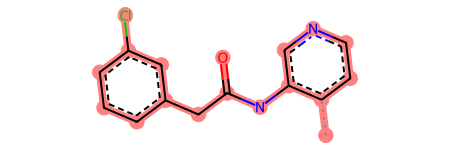

In [320]:
scaffold

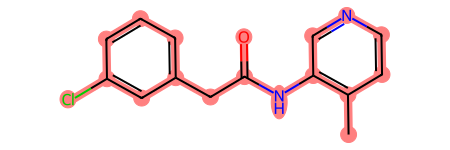

In [321]:
mols[0]

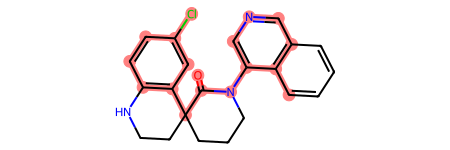

In [322]:
mols[1]

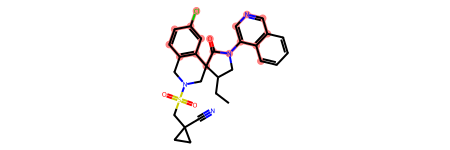

In [323]:
mols[2]

In [328]:
def draw_ligs(rdkitmols, legends, use_svg=True):
    # Find the atoms to highlight
    # highlight = [mol.GetSubstructMatch(rdkit_scaffold) for mol in rdkitmols]
    
    # Set Draw Options
    dopts = Draw.rdMolDraw2D.MolDrawOptions()
    dopts.setHighlightColour((68 / 256, 178 / 256, 212 / 256))
    dopts.highlightBondWidthMultiplier = 16
    d2d = Draw.MolDraw2DCairo(1600, 1600)
    # print("Preparing depictions")
    # for mol in rdkitmols:
    #     Chem.RemoveHs(mol)
    #     Draw.MolToImage(mol, size=(400, 400), options=dopts)
    #     rdDepictor.Compute2DCoords(mol)
    #     rdDepictor.StraightenDepiction(mol)
    #     d2d.DrawMolecule(mol)
    # 
    # Draw the molecules
    img = Draw.MolsToGridImage(rdkitmols, 
                               molsPerRow=6, 
                               subImgSize=(200, 200), 
                               # highlightAtomLists=highlight,
                               useSVG= use_svg,
                               legends = legends,
                               drawOptions=dopts)
    return img

In [333]:
# legends = [f"{ligand.compound_name} ({ligand.tags['xtal_name']})" for ligand in ligs]
legends = [f"{ligand.compound_name}" for ligand in ligs]

In [334]:
img = draw_ligs(mols, legends=legends)

In [335]:
img = draw_ligs(mols, legends=legends, use_svg=True)
with open(f"lig_examples.svg", "w") as f:
    f.write(img.data)

img = draw_ligs(mols, legends=legends, use_svg=False)
with open(f"lig_examples.png", "wb") as f:
    f.write(img.data)

In [287]:
ex = ligs[1].to_rdkit()
# remove hydrogns
ex = Chem.RemoveHs(ex)

In [131]:
align_to_scaffold(scaff, [ex])

RuntimeError: No sub-structure match found between the probe and query mol

In [141]:
from asapdiscovery.data.backend.openeye import oechem, oedepict
import numpy as np

In [153]:
def get_mcs_from_mcs_mol(mcs_mol: oechem.OEMol):
    # Prep MCS
    atomexpr = (
        oechem.OEExprOpts_Aromaticity
        # | oechem.OEExprOpts_AtomicNumber
        # | oechem.OEExprOpts_FormalCharge
        | oechem.OEExprOpts_RingMember
    )
    bondexpr = ( 
            oechem.OEExprOpts_Aromaticity 
            # | oechem.OEExprOpts_BondOrder
    )
    # create maximum common substructure object
    pattern_query = oechem.OEQMol(mcs_mol)
    pattern_query.BuildExpressions(atomexpr, bondexpr)
    mcss = oechem.OEMCSSearch(pattern_query)
    mcss.SetMCSFunc(oechem.OEMCSMaxAtoms())
    return mcss


def get_n_rows_and_cols(n_mols, mols_per_row=None):
    if mols_per_row is not None:
        return int(np.ceil(n_mols / mols_per_row)), mols_per_row
        
    return int(np.round(np.sqrt(n_mols))), int(np.ceil(np.sqrt(n_mols)))


def get_row_col(i, rows, cols, zero_indexed=True):
    row = i // cols + (0 if zero_indexed else 1)
    col = i % cols + (0 if zero_indexed else 1)
    return int(row), int(col)

In [154]:
def plot_ligands_with_mcs(
    filename: str,
    mcs_mol: oechem.OEMol = None,
    mols=list[oechem.OEMol],
    max_width: int = 4,
    quantum_width=150,
    quantum_height=200,
    reference="smallest",
        mols_per_row=None,
):
    # count n ligands + the mcs_mol
    n_ligands = len(mols)  # + 1
    print(f"{n_ligands} molecules to plot")
    print([mol.GetTitle() for mol in mols])

    mol_array = np.array(mols)
    n_atoms = np.array([mol.NumAtoms() for mol in mols])
    print(n_atoms)

    if reference == "smallest":
        order = np.argsort(n_atoms)
        mol_array = mol_array[order]
        n_atoms = n_atoms[order]

        smallest_sort = np.argmin(n_atoms)
        refmol = mol_array[smallest_sort]
        mols = np.delete(mol_array, smallest_sort)
    elif reference == "largest":
        order = np.argsort(-n_atoms)
        mol_array = mol_array[order]
        n_atoms = n_atoms[order]

        largest_sort = np.argmax(n_atoms)
        refmol = mol_array[largest_sort]
        mols = np.delete(mol_array, largest_sort)
    elif reference == "mcs_mol" and mcs_mol is not None:
        order = np.argsort(n_atoms)
        mol_array = mol_array[order]
        n_atoms = n_atoms[order]

        mols = mol_array
        refmol = mcs_mol
        n_ligands += 1
    else:
        raise NotImplementedError

    # Prepare image
    rows, cols = get_n_rows_and_cols(n_ligands, mols_per_row=mols_per_row)

    print(f"Generating a figure with {rows} rows and {cols} columns")
    image = oedepict.OEImage(quantum_width * cols, quantum_height * rows)
    grid = oedepict.OEImageGrid(image, rows, cols)
    opts = oedepict.OE2DMolDisplayOptions(
        grid.GetCellWidth(), grid.GetCellHeight(), oedepict.OEScale_AutoScale
    )
    opts.SetTitleLocation(oedepict.OETitleLocation_Bottom)
    opts.SetHydrogenStyle(oedepict.OEHydrogenStyle_Hidden)

    refscale = oedepict.OEGetMoleculeScale(refmol, opts)

    oedepict.OEPrepareDepiction(refmol)

    mcss = get_mcs_from_mcs_mol(refmol)
    oedepict.OEPrepareAlignedDepiction(refmol, mcss)

    opts.SetScale(refscale)
    refdisp = oedepict.OE2DMolDisplay(refmol, opts)
    refcell = grid.GetCell(1, 1)

    oedepict.OERenderMolecule(refcell, refdisp)

    print([mol.GetTitle() for mol in mols])
    for i, fitmol in enumerate(mols):
        i += 1
        row, col = get_row_col(i, rows, cols, zero_indexed=False)
        print(row, col)

        alignres = oedepict.OEPrepareAlignedDepiction(fitmol, mcss)

        if not alignres.IsValid():
            oedepict.OEPrepareDepiction(fitmol)

        fitdisp = oedepict.OE2DMolDisplay(fitmol, opts)
        if alignres.IsValid():
            fitabset = oechem.OEAtomBondSet(
                alignres.GetTargetAtoms(), alignres.GetTargetBonds()
            )
            oedepict.OEAddHighlighting(
                fitdisp,
                oechem.OEBlueTint,
                oedepict.OEHighlightStyle_BallAndStick,
                fitabset,
            )
        fitcell = grid.GetCell(row, col)
        oedepict.OERenderMolecule(fitcell, fitdisp)

    oedepict.OEWriteImage(filename, image)

In [155]:
plot_ligands_with_mcs('test.png', mols=[lig.to_oemol() for lig in ligs], reference='largest', mols_per_row=3)

3 molecules to plot
['', '', '']
[31 47 64]
Generating a figure with 1 rows and 3 columns
['', '']
1 2
1 3
